### AlphaZero Tutorial

The goal of this tutorial is to take you through the main steps of the algorithm to help anyone trying to understand its inner workings

In [4]:
from vikingzero.agents.alphago import AlphaZero
from vikingzero.environments.tictactoe_env import TicTacToe
from vikingzero.search import ZeroMCTS, ZeroNode

import numpy as np
import os
import pydot
import yaml


from IPython.display import Image, display

In [5]:
curr_dir = os.path.abspath(os.getcwd())

Define path to a yaml config file. Examples should exist in the notebooks and tests directory of the vikingzero project

In [8]:
CONFIG = curr_dir +  "/tictactoe_alphago.yaml"

We first define some helper function
* uct calculate the uct score for a given node and action (more below to explain what that means)
* _repr_png_ gives us a png representation of our search tree

In [10]:
def uct(mcts,node,a):
    n_s = mcts.calculate_NS(node)
    p_a = mcts._Ps[node][a]
    return mcts._Qsa[(node,a)] / (mcts._Nsa[(node,a)] + 1) + mcts._c * p_a * (np.sqrt(n_s) / (1 + mcts._Nsa[(node,a)]))

In [11]:
def _repr_png_(mcts):
    g = pydot.Dot(graph_type="digraph")

    num_points = mcts.points
    for i in range(num_points):
        node = mcts.dec_pts[i]
        if node.terminal():

            node_label = f" Leaf: Winner = {node.winner} "
        else:
            node_label = " Player: " + str(mcts.dec_pts[i].player) + "\n"
            #if node not in mcts._Vs:
                #mcts._Vs[node] = 0
            v = mcts._Vs[node]
            node_label = node_label + f"Vs: {v:.3f}"

        g.add_node(pydot.Node('node%d' % i, label=node_label))

    for i in range(num_points):

        parent = mcts.dec_pts[i]
        for child in mcts.children[i]:
            uct_child = uct(mcts,parent,child.parent_action)
            c_index = mcts.dec_pts.index(child)
            p_c = np.round(mcts._Ps[parent].copy()[child.parent_action],2)
            Qsa = mcts._Qsa[(parent,child.parent_action)]
            Nsa = mcts._Nsa[(parent,child.parent_action)]

            edge_label = f"action={child.parent_action} \n"
            edge_label += f"Qsa = {Qsa: .3f} \n"
            edge_label += f"Nsa = {Nsa} \n"
            edge_label += f"Ps = {p_c:.3f}\n"
            edge_label += f"UCT = {uct_child:.3f}"

            edge = pydot.Edge('node%d' % i, 'node%d' % c_index,label=edge_label)
            g.add_edge(edge)

    plt = Image(g.create_png())
    display(plt)


In [12]:
tictactoe = TicTacToe()

env = tictactoe

root = ZeroNode(state=env.board, player=1, winner=0, parent=None, parent_action=None)

Load Config File

In [13]:
with open(CONFIG) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


In [14]:
agent_config = config["agent_config"]["agent1"]
del agent_config["agent"]

In [15]:
alpha_agent = AlphaZero(env,**agent_config)

In [16]:
print(root)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [97]:
zero_mcts = ZeroMCTS(env,alpha_agent._nn,alpha_agent.node_to_state,dir_eps=0)

In [106]:
zero_mcts.children.append([])
zero_mcts.dec_pts.append(root)
zero_mcts.parents.append(None)
zero_mcts.root = root

In [107]:
zero_mcts._Vs

defaultdict(float, {})

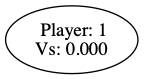

In [108]:
_repr_png_(zero_mcts)

SEARCH STEPS

## Step1: Select

In [79]:
def run_select(root):

    if root in zero_mcts.dec_pts:
        node_index = zero_mcts.dec_pts.index(root)
        root = zero_mcts.dec_pts[node_index] # Perfer to use the node that already exists

    if root not in zero_mcts.dec_pts:
        if root != zero_mcts.root:
            parent_index = zero_mcts.dec_pts.index(root.parent)
            zero_mcts.children[parent_index].append(root)
            a = root.parent_action
            zero_mcts._Qsa[(root.parent, a)] = 0
            zero_mcts._Nsa[(root.parent, a)] = 0

        zero_mcts.dec_pts.append(root)
        zero_mcts.children.append([])


    path = zero_mcts.search(root)

    return path

In [145]:
path = run_select(root)

In [146]:
for n,a in path:
    print(n)
    print(a)

[[2. 0. 0.]
 [2. 0. 1.]
 [0. 0. 1.]]
2
[[2. 0. 1.]
 [2. 0. 1.]
 [0. 0. 1.]]
None


STEP 2: EXPAND and EVALUATE

In [147]:
leaf,a = path[-1]

In [148]:
zero_mcts.expand(leaf)

$UCT = Q(s,a) + c*P(s,a)*\frac{\sqrt{\sum{N(s,b}}}{N(s,a) + 1}$

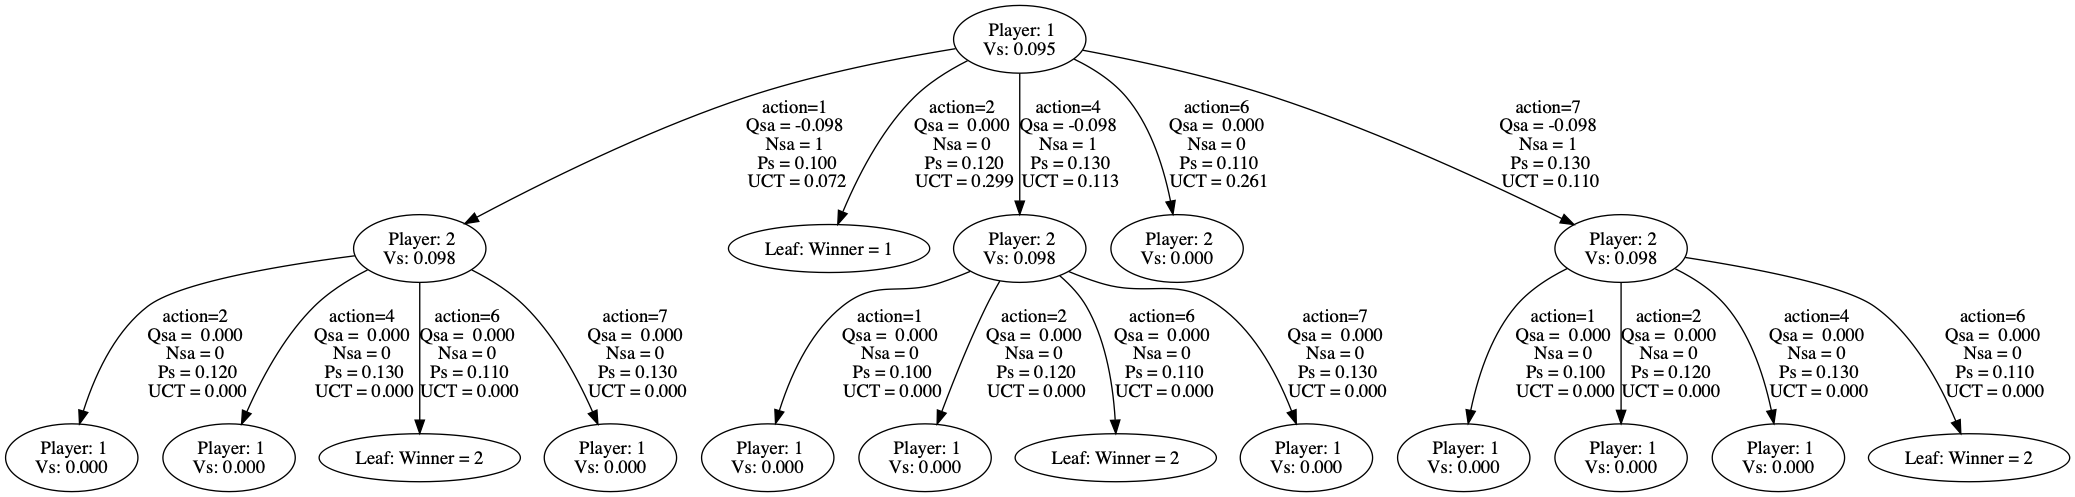

In [149]:
_repr_png_(zero_mcts)

In [150]:
reward = zero_mcts.simulate(leaf)

In [151]:
reward

-1

STEP 3: BACKUP

In [152]:
zero_mcts.backup(path, reward)

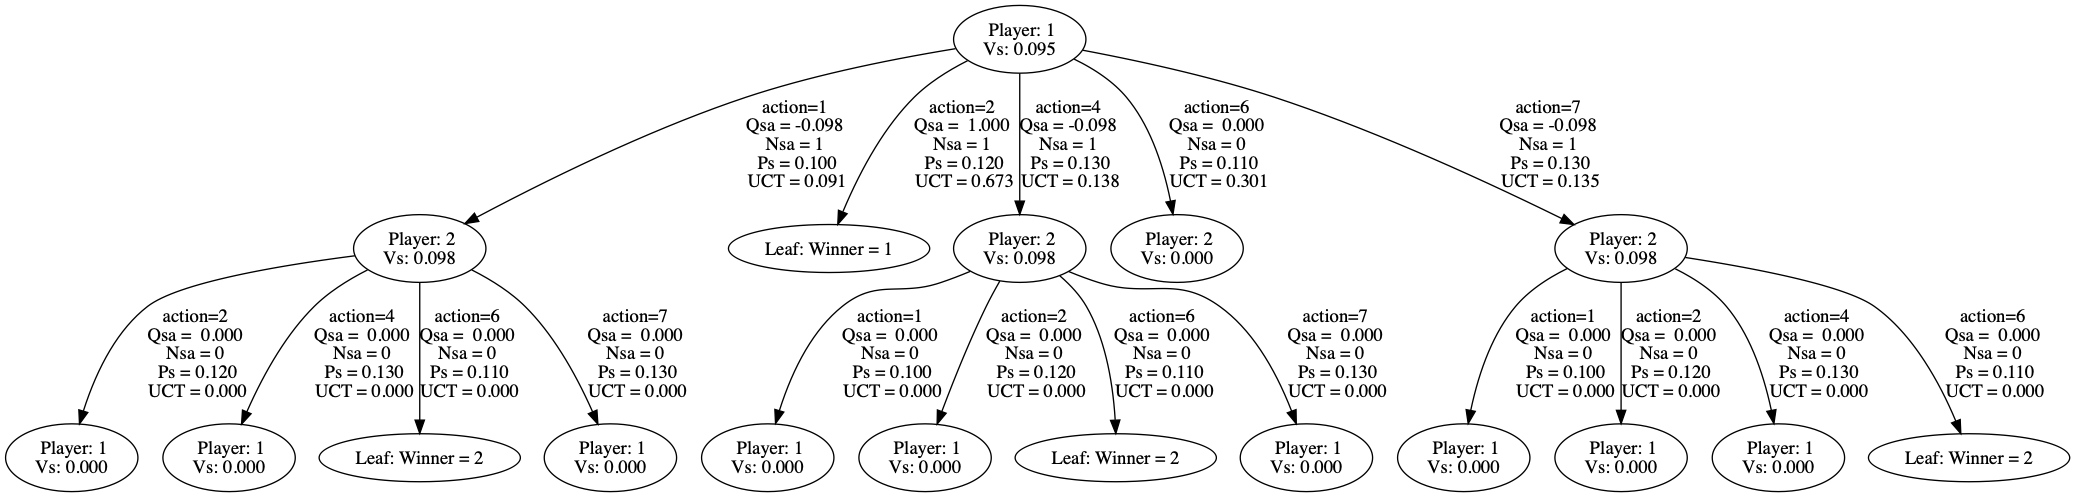

In [153]:
_repr_png_(zero_mcts)

In [49]:
from vikingzero.run_agent import run_agent

Processing Yaml Config File
----------------PASSED PARAMS -----------------------
{
    "agent_config": {
        "agent1": {
            "agent": "AlphaZero",
            "augment_input": true,
            "batch_size": 8,
            "c": 1.41,
            "dirichlet_noise": 1,
            "dropout": 0.3,
            "epochs": 25,
            "epsilon": 0.2,
            "input_height": 3,
            "input_width": 3,
            "lr": 0.001,
            "max_mem_size": 10000,
            "minimax_lookup_path": "/Users/befeltingu/Documents/Github/VikingZeroDev/tests/minimax_state_actions.npy",
            "momentum": 0.9,
            "n_sim": 15,
            "network_path": "",
            "network_type": "cnn_small",
            "num_channels": 32,
            "optimizer": "Adam",
            "output_size": 9,
            "player": 1,
            "state_lookup_path": "/Users/befeltingu/Documents/Github/VikingZeroDev/tests/state_dict.npy",
            "t_threshold": 8,
            "w

  0%|          | 0/15 [00:00<?, ?it/s]

Done loading configurations now running experiment
Running iteration 0
Training time =0.006143252054850261 For 10 iters


  7%|▋         | 1/15 [00:00<00:10,  1.36it/s]

Training network time =0.004568286736806234
Running iteration 1
Training time =0.004618914922078451 For 10 iters


 13%|█▎        | 2/15 [00:01<00:09,  1.36it/s]

Training network time =0.005680497487386068
Running iteration 2
Training time =0.004723648230234782 For 10 iters


 20%|██        | 3/15 [00:02<00:08,  1.43it/s]

Training network time =0.004544544219970703
Running iteration 3
Training time =0.0032321015993754068 For 10 iters


 27%|██▋       | 4/15 [00:02<00:06,  1.57it/s]

Training network time =0.004216249783833822
Running iteration 4
Training time =0.004179104169209798 For 10 iters


 33%|███▎      | 5/15 [00:03<00:06,  1.60it/s]

Training network time =0.004482698440551758
Running iteration 5
Training time =0.0032892465591430665 For 10 iters


 40%|████      | 6/15 [00:03<00:05,  1.67it/s]

Training network time =0.004262181123097738
Running iteration 6
Training time =0.0031006852785746258 For 10 iters


 47%|████▋     | 7/15 [00:04<00:04,  1.73it/s]

Training network time =0.004252982139587402
Running iteration 7
Training time =0.0030152638753255206 For 10 iters


 53%|█████▎    | 8/15 [00:04<00:03,  1.79it/s]

Training network time =0.004835232098897298
Running iteration 8
Training time =0.0029031833012898764 For 10 iters


 60%|██████    | 9/15 [00:05<00:03,  1.79it/s]

Training network time =0.004949351151784261
Running iteration 9
Training time =0.00303878386815389 For 10 iters


 67%|██████▋   | 10/15 [00:05<00:02,  1.83it/s]

Training network time =0.004877916971842448
Running iteration 10
Training time =0.0031296173731486005 For 10 iters


 73%|███████▎  | 11/15 [00:06<00:02,  1.85it/s]

Training network time =0.004921146233876546
Running iteration 11
Training time =0.0046067357063293455 For 10 iters


 80%|████████  | 12/15 [00:06<00:01,  1.81it/s]

Training network time =0.004383265972137451
Running iteration 12
Training time =0.002850647767384847 For 10 iters


 87%|████████▋ | 13/15 [00:07<00:01,  1.82it/s]

Training network time =0.004841148853302002
Running iteration 13
Training time =0.004951254526774088 For 10 iters


 93%|█████████▎| 14/15 [00:08<00:00,  1.71it/s]

Training network time =0.004583136240641276
Running iteration 14
Training time =0.003250014781951904 For 10 iters


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


Training network time =0.00439911683400472
Done running experiment
Showing results


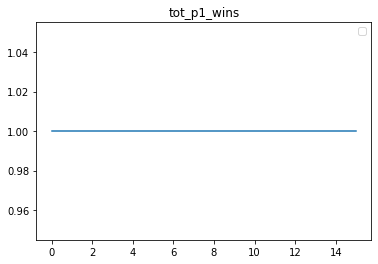

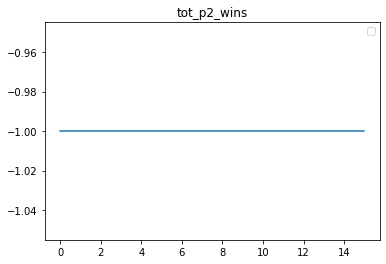

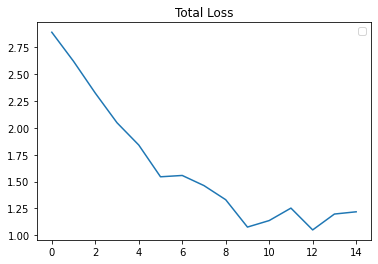

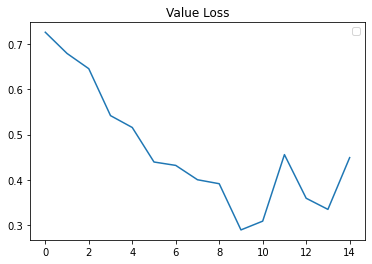

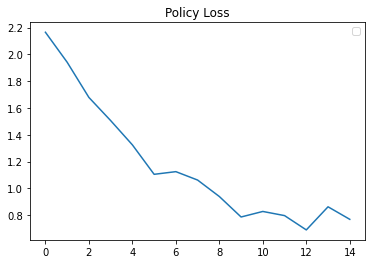

In [74]:
logger,trained_agent = run_agent(CONFIG)